In [2]:
import pandas as pd
import numpy as np
import re
import nltk 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')

%matplotlib inline

data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

airline_tweets.head(5)

[nltk_data] Downloading package stopwords to /home/wei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


<AxesSubplot:xlabel='airline'>

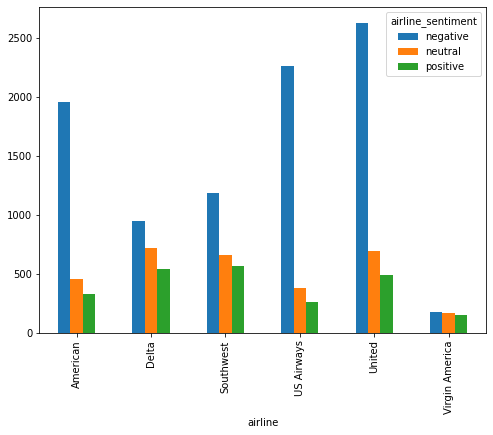

In [4]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

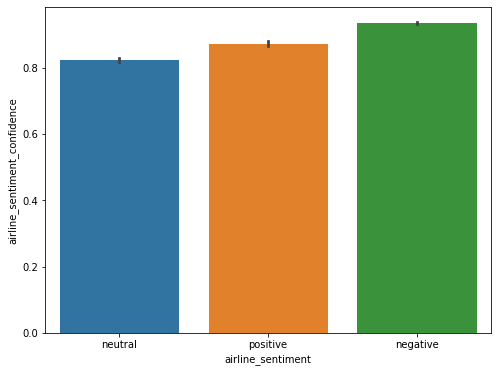

In [5]:
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)

In [6]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [7]:
def preprocess(feature):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(feature))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature) 

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    return processed_feature

In [8]:
import re

processed_features = []

for sentence in features:

    processed_features.append(preprocess(sentence))

In [9]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

processed_features = vectorizer.fit_transform(processed_features).toarray()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [11]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [12]:
predictions = text_classifier.predict(X_test)

In [13]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


In [14]:
test_input = [preprocess("@VirginAmerica I didn't today... Must mean I need to take another trip!")]

test_feature = vectorizer.transform(test_input).toarray()

test_prediction = text_classifier.predict(test_feature)

test_prediction

array(['neutral'], dtype=object)

In [15]:
model_path = "sklearn_model.pickle"
vectorizer_path = "sklearn_vectorizer.pickle"

pickle.dump(text_classifier, open(model_path, "wb"))

pickle.dump(vectorizer, open(vectorizer_path, "wb"))

In [16]:
#load model 
file_to_load = open(model_path, 'rb')
loaded_classifier = pickle.load(file_to_load)

print(type(loaded_classifier))

loaded_vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'), vocabulary = pickle.load(open(vectorizer_path, "rb")))
loaded_prediction = loaded_classifier.predict(test_feature)

loaded_prediction

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


array(['neutral'], dtype=object)